<br>

<div align=center><font color=maroon size=6><b>Download dataset</b></font></div>

<br>

<font size=4><b>References:</b></font>
1. TF2 official tutorials: <a href="https://www.tensorflow.org/tutorials" style="text-decoration:none;">TensorFlow Tutorials</a> 
    * `TensorFlow > Learn > TensorFlow Core > `Tutorials > <a href="" style="text-decoration:none;"></a>
        * Run in <a href="" style="text-decoration:none;">Google Colab</a>

<br>
<br>
<br>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

D:\Programs\Anaconda3\envs\tfg\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<br>

In [2]:
print(tf.__version__)

2.8.0


<br>
<br>
<br>
<br>
<br>

## tf.keras.datasets.XXX.load_data()

In [3]:
# help(tf.keras.datasets.fashion_mnist.load_data)
# 
# Returns:
# Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.

In [4]:
# 默认下载保存路径：C:\Users\18617\.keras\datasets
# 通过创建软连接来修改下载保存路径：（cmd 任意当前路径下）
# mklink /J "C:\Users\18617\.keras\datasets" "D:\KeepStudy\0_Coding\0_dataset"


fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Add a dimension to the array -> new shape == (28, 28, 1)
# This is done because the first layer in our model is a convolutional
# layer and it requires a 4D input (batch_size, height, width, channels).
# batch_size dimension will be added later on.
train_images = train_images[..., None]
test_images = test_images[..., None]

# Scale the images to the [0, 1] range.
train_images = train_images / np.float32(255)
test_images = test_images / np.float32(255)

<br>
<br>
<br>
<br>
<br>

## tf.keras.utils.get_file()

In [5]:
# help(tf.keras.utils.get_file)

# Downloads a file from a URL if it not already in the cache.
#
# Files in tar, tar.gz, tar.bz, and zip formats can also be extracted.
# Passing a hash will verify the file after download.
#
# Returns:
# Path to the downloaded file

<br>
<br>

### .tgz

In [6]:
# 默认下载保存路径：C:\Users\18617\.keras\datasets
# 修改后的下载保存路径：D:\KeepStudy\0_Coding\0_dataset
#
# 注意： 默认 cache_subdir='datasets'

# 也可通过创建软连接来修改下载保存路径：（cmd 任意当前路径下）
# mklink /J "C:\Users\18617\.keras\datasets" "D:\KeepStudy\0_Coding\0_dataset"


import pathlib

# flower_photos.tgz
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True,
                                   
                                   cache_dir="D:/KeepStudy/0_Coding/0_dataset/",
                                   cache_subdir="")
data_dir = pathlib.Path(data_dir)

In [7]:
data_dir

WindowsPath('D:/KeepStudy/0_Coding/0_dataset/flower_photos')

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


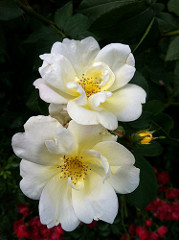

In [9]:
import PIL

roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [10]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

<br>

The above Keras preprocessing utility—`tf.keras.utils.image_dataset_from_directory`—is a convenient way to create a `tf.data.Dataset` from a directory of images.

For finer grain control, you can write your own input pipeline using `tf.data`. This section shows how to do just that, beginning with the file paths from the TGZ file you downloaded earlier.

In [12]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [13]:
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
list_ds

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [14]:
for f in list_ds.take(5):
    print(f.numpy())

b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\tulips\\4589624702_b6baa83699_m.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\daisy\\21626652132_97e1318bb8_m.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\roses\\16666836810_216f50e9c3_m.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\tulips\\14071516088_b526946e17_n.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\daisy\\8740807508_0587f5b7b7.jpg'


In [15]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*')
                               if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [16]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

You can print the length of each dataset as follows:

In [17]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a short function that converts a file path to an `(img, label)` pair:

In [18]:
import os
os.path.sep

'\\'

In [19]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [20]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [21]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [23]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


In [24]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

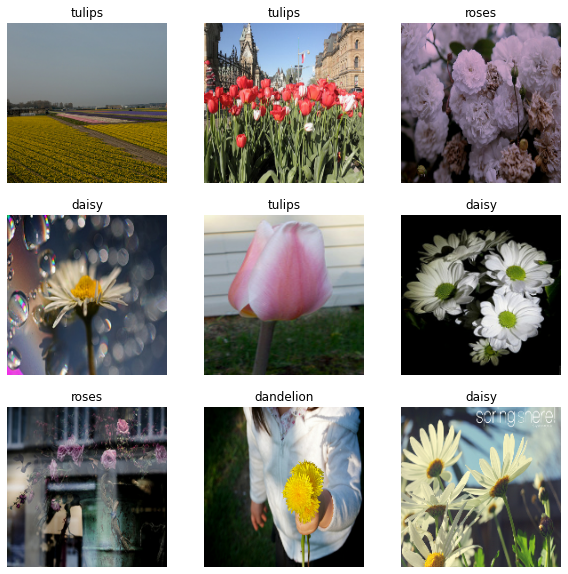

In [25]:
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

接下来配置好 model 之后，就可以用这些数据来训练模型：

```python
model.fit(train_ds,
          validation_data=val_ds,
          epochs=3)
```

<br>
<br>

### .npz

In [26]:
# mnist.npz
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

path = tf.keras.utils.get_file('mnist.npz',
                               DATA_URL,
                               cache_dir='D:/KeepStudy/0_Coding',
                               cache_subdir='0_dataset')

In [27]:
with np.load(path) as data:
    train_examples = data['x_train']
    train_labels = data['y_train']
    test_examples = data['x_test']
    test_labels = data['y_test']

Assuming you have an array of examples and a corresponding array of labels, pass the two arrays as a tuple into `tf.data.Dataset.from_tensor_slices` to create a `tf.data.Dataset`.

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

In [29]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

接下来配置好 model 之后，就可以用这些数据来训练模型：
```python
model.fit(train_dataset, epochs=10)
```

<br>
<br>

### .csv

In [30]:
csv_file = tf.keras.utils.get_file('heart.csv', 
                                   'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv',
                                   cache_dir="D:/KeepStudy/0_Coding",
                                   cache_subdir="0_dataset")

In [31]:
import pandas as pd

In [32]:
df = pd.read_csv(csv_file)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


<br>
<br>
<br>
<br>
<br>

## tfds.load()

In [33]:
# help(tfds.load)

In [34]:
# 默认下载保存路径：C:\Users\18617\tensorflow_datasets
# 修改后的下载保存路径：D:\KeepStudy\0_Coding\0_dataset
# 因为有些 tfds 的 load() 之外的其它方法下载数据集时不小心也是放到默认路径中。故追加创建软连接：
#（cmd 任意当前路径下）
# mklink /J "C:\Users\18617\tensorflow_datasets" "D:\KeepStudy\0_Coding\0_dataset\tensorflow_datasets"

(train_ds, val_ds, test_ds), metadata = tfds.load('tf_flowers',
                                                  split=['train[:80%]', 
                                                         'train[80%:90%]', 
                                                         'train[90%:]'],
                                                  with_info=True,
                                                  as_supervised=True,
                                                  data_dir="D:/KeepStudy/0_Coding/0_dataset/tensorflow_datasets/")

<br>
<br>
<br>
<br>
<br>

## pd.read_csv()

In [35]:
import pandas as pd

In [36]:
abalone_train = pd.read_csv("https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv",
                            names=["Length", "Diameter", "Height", 
                                   "Whole weight", "Shucked weight",
                                   "Viscera weight", "Shell weight", "Age"])

abalone_train.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,0.435,0.335,0.110,0.334,0.1355,0.0775,0.0965,7
1,0.585,0.450,0.125,0.874,0.3545,0.2075,0.2250,6
2,0.655,0.510,0.160,1.092,0.3960,0.2825,0.3700,14
3,0.545,0.425,0.125,0.768,0.2940,0.1495,0.2600,16
4,0.545,0.420,0.130,0.879,0.3740,0.1695,0.2300,13


<br>
<br>
<br>